In [1]:
import numpy as np
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
datagen = ImageDataGenerator(rescale=1./255 ,preprocessing_function=preprocess_input)

train_datagen = datagen.flow_from_directory('train',
                                            batch_size=3,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

val_datagen = datagen.flow_from_directory('val',
                                            batch_size=3,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='binary')

Found 180 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [3]:
model = VGG16(weights='imagenet', include_top=False)

inp = Input(shape=(224, 224, 3), batch_size=3)

x = model(inp)
x = GlobalMaxPooling2D()(x)

model_feature_extractor = Model(inputs=[inp], outputs=[x])

In [5]:
X_train = np.zeros((180, 512), dtype=np.float32)
y_train = np.zeros((180))

X_val = np.zeros((220, 512), dtype=np.float32)
y_val = np.zeros((220))

In [6]:
for i in tqdm(range(0, 180, 3)):
    batch = train_datagen.next()
    X_train[i:i + 3] = model_feature_extractor.predict(batch[0])
    y_train[i:i + 3] = batch[1]

for i in tqdm(range(0, 220, 3)):
    batch = val_datagen.next()
    X_val[i:i + 3] = model_feature_extractor.predict(batch[0])
    y_val[i:i + 3] = batch[1]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [32:23<00:00, 26.26s/it]


In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(180, 512) (180,)
(220, 512) (220,)


In [8]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    # Plot both Loss & Accuracy in Subplot
  # creat accuracy plot
    axs[0].plot(history.history['acc'], label='train accuracy')
    axs[0].plot(history.history['val_acc'], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='best')
    axs[0].set_title('Accuracy eval')

  # creat loss plot
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='test loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='best')
    axs[1].set_title('Loss eval')

    plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import datetime

In [10]:
clf_model =  Sequential()

clf_model.add(Dense(128, activation='relu', input_dim=512,
                    kernel_regularizer=l2(0.001)))
clf_model.add(Dropout(0.3))

clf_model.add(Dense(1, activation='sigmoid'))

clf_model.summary()

clf_model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 65,793
Trainable params: 65,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
60/60 - 8s - loss: 0.9229 - acc: 0.6111 - val_loss: 0.7702 - val_acc: 0.7136
Epoch 2/50
60/60 - 1s - loss: 0.7864 - acc: 0.6889 - val_loss: 0.7165 - val_acc: 0.7273
Epoch 3/50
60/60 - 1s - loss: 0.6957 - acc: 0.7278 - val_loss: 0.6337 - val_acc: 0.7818
Epoch 4/50
60/60 - 1s - loss: 0.6043 - acc: 0.8111 - val_loss: 0.5936 - val_acc: 0.8182
Epoch 5/50
60/60 - 1s - loss: 0.5576 - acc: 0.8500 - val_loss: 0.5843 - val_acc: 0.8182
Epoch 6/50
60/60 - 1s - loss: 0.4648 - acc: 0.9222 - val_loss: 0.5127 - val_acc: 0.8909
Epoch 7/50
60/60 - 1s - loss: 0.4926 - acc: 0.8833 - val_loss: 0.4920 - val_acc: 0.8955
Epoch 8/50
60/60 - 1s - loss: 0.4323 - acc: 0.9222 - val_loss: 0.4835 - val_acc: 0.8909
Epoch 9/50
60/60 - 1s - loss: 0.4295 - acc: 0.8944 - val_loss: 0.4844 - val_acc: 0.8864
Epoch 10/50
60/60 - 1s - loss: 0.3967 - acc: 0.9111 - val_loss: 0.4699 - val_acc: 0.8909
Epoch 11/50
60/60 - 1s - loss: 0.4100 - acc: 0.9111 - val_loss: 0.4484 - val_acc: 0.9045
Epoch 12/50
60/60 - 1s - loss:

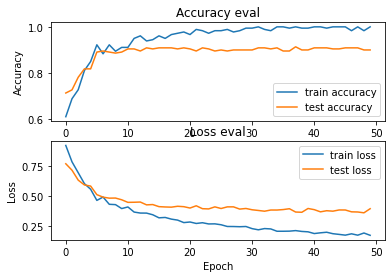

In [11]:
res = clf_model.fit(X_train, y_train.reshape(-1, 1), epochs=50, batch_size=3,
              validation_data=(X_val, y_val.reshape(-1, 1)), verbose=2)

plot_history(res)

In [14]:
test_filenames = os.listdir("test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [15]:
test_df.head()

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


In [16]:
test_datagen = datagen.flow_from_dataframe(
    test_df, 
    "test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=3,
    shuffle=False
)

Found 80 validated image filenames.


In [ ]:
print(int(12500 / 32) * 32)

In [17]:
X_test = np.zeros((80, 512), dtype=np.float32)

In [18]:
for i in tqdm(range(0, 80, 3)):
    batch = test_datagen.next()
    X_test[i:i + 3] = model_feature_extractor.predict(batch)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [12:23<00:00, 27.55s/it]


In [20]:
preds = clf_model.predict(X_test)

In [27]:
for i in range(len(preds)):
    if preds[i] >= 0.5:
        preds[i] = 1
    else:
        preds[i] = 0

In [24]:
predictions = pd.DataFrame()
predictions["id"] = np.arange(1, 81)
predictions["target"] = preds

predictions.to_csv('Pejman_submission.csv', index=False, header=predictions.columns)
predictions.head(10)

,id,target
0,1,1.0
1,2,0.0
2,3,0.0
3,4,1.0
4,5,1.0
5,6,0.0
6,7,1.0
7,8,1.0
8,9,1.0
9,10,0.0


In [25]:
predictions['target'].value_counts()

0.0    47
1.0    33
Name: target, dtype: int64

In [28]:

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)

